# L1 norm prior experiment

This code attempts to learn the 64D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 5395.3115234375
iteration 0 loss 1808.81201171875


iteration 5000 loss 31.56450843811035


iteration 10000 loss 1.929266333580017


iteration 15000 loss 0.57011878490448


iteration 20000 loss 0.3114825487136841


iteration 25000 loss 0.1913757473230362


iteration 30000 loss 0.12193256616592407


iteration 35000 loss 0.09054607897996902


iteration 40000 loss 0.06884957104921341


iteration 45000 loss 0.05187239125370979


iteration 50000 loss 0.042035333812236786


iteration 55000 loss 0.03386276215314865


iteration 60000 loss 0.02851857803761959


iteration 65000 loss 0.0235696192830801


iteration 70000 loss 0.019620923325419426


iteration 75000 loss 0.017089471220970154


iteration 80000 loss 0.014232171699404716


iteration 85000 loss 0.01301913894712925


iteration 90000 loss 0.010459627024829388


iteration 95000 loss 0.009378363378345966


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.007851853035390377


iteration 105000 loss 0.007188898976892233


iteration 110000 loss 0.006181346718221903


iteration 115000 loss 0.005459918640553951


iteration 120000 loss 0.004772327374666929


iteration 125000 loss 0.004150040913373232


iteration 130000 loss 0.0036260318011045456


iteration 135000 loss 0.003192765871062875


iteration 140000 loss 0.002796918386593461


iteration 145000 loss 0.0024592725094407797


iteration 150000 loss 0.002173474058508873


iteration 155000 loss 0.0019122852245345712


iteration 160000 loss 0.0017075228970497847


iteration 165000 loss 0.001535904943011701


iteration 170000 loss 0.0013698836555704474


iteration 175000 loss 0.0012065916089341044


iteration 180000 loss 0.00108724320307374


iteration 185000 loss 0.0009787844028323889


iteration 190000 loss 0.0008653388940729201


iteration 195000 loss 0.0007796154823154211


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.0007029423140920699


iteration 205000 loss 0.0006666600238531828


iteration 210000 loss 0.0005908629973419011


iteration 215000 loss 0.0005335510359145701


iteration 220000 loss 0.00047480754437856376


iteration 225000 loss 0.0004201097472105175


iteration 230000 loss 0.00038264982867985964


iteration 235000 loss 0.00034664731356315315


iteration 240000 loss 0.00030377483926713467


iteration 245000 loss 0.00027618659078143537


iteration 250000 loss 0.0002447415899951011


iteration 255000 loss 0.00021953103714622557


iteration 260000 loss 0.00019894237630069256


iteration 265000 loss 0.00017893497715704143


iteration 270000 loss 0.00016035565931815654


iteration 275000 loss 0.00014612660743296146


iteration 280000 loss 0.00013259136176202446


iteration 285000 loss 0.0001192910858662799


iteration 290000 loss 0.00010730823851190507


iteration 295000 loss 9.754547500051558e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 8.810665167402476e-05


iteration 305000 loss 8.272096602013335e-05


iteration 310000 loss 7.493240991607308e-05


iteration 315000 loss 6.727584695909172e-05


iteration 320000 loss 6.082587060518563e-05


iteration 325000 loss 5.4135482059791684e-05


iteration 330000 loss 4.956899647368118e-05


iteration 335000 loss 4.4342927139950916e-05


iteration 340000 loss 3.9531725633423775e-05


iteration 345000 loss 3.584336445783265e-05


iteration 350000 loss 3.220622966182418e-05


iteration 355000 loss 2.96335929306224e-05


iteration 360000 loss 2.666508407855872e-05


iteration 365000 loss 2.4560436941101216e-05


iteration 370000 loss 2.2277814423432574e-05


iteration 375000 loss 2.0050816601724364e-05


iteration 380000 loss 1.853205139923375e-05


iteration 385000 loss 1.674001759965904e-05


iteration 390000 loss 1.5581714251311496e-05


iteration 395000 loss 1.431404598406516e-05


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 1.3200799912738148e-05


iteration 405000 loss 1.3063352525932714e-05


iteration 410000 loss 1.2082025023119058e-05


iteration 415000 loss 1.109024651668733e-05


iteration 420000 loss 1.0197813935519662e-05


iteration 425000 loss 9.3830003606854e-06


iteration 430000 loss 8.634724508738145e-06


iteration 435000 loss 7.94607331044972e-06


iteration 440000 loss 7.311127774300985e-06


iteration 445000 loss 6.726130777678918e-06


iteration 450000 loss 6.185641723277513e-06


iteration 455000 loss 5.688061264663702e-06


iteration 460000 loss 5.229742782830726e-06


iteration 465000 loss 4.807250661542639e-06


iteration 470000 loss 4.417867330630543e-06


iteration 475000 loss 4.058867034473224e-06


iteration 480000 loss 3.728714546014089e-06


iteration 485000 loss 3.425167506065918e-06


iteration 490000 loss 3.1462066090170993e-06


iteration 495000 loss 2.8907018077006796e-06


L2 loss -- Plot

loss -60.735931396484375


loss -293.0068359375


loss -404.03887939453125


loss -490.95111083984375


loss -569.7025146484375


loss -642.345458984375


loss -709.4752197265625


loss -771.25732421875


loss -827.66845703125


loss -878.640380859375


loss -924.1338500976562


loss -964.1753540039062


loss -998.8802490234375


loss -1028.4573974609375


loss -1053.1993408203125


loss -1073.469970703125


loss -1089.6888427734375


loss -1102.311279296875


loss -1111.814697265625


loss -1118.689208984375


loss -1123.425537109375


loss -1126.4990234375


loss -1128.349609375


loss -1129.3623046875


loss -1129.851806640625


loss -1130.0528564453125


loss -1130.11962890625


loss -1130.136474609375


loss -1130.139404296875


loss -1130.1396484375


loss -1130.1396484375


loss -1130.1396484375


loss -1130.1396484375


loss -1130.1396484375


loss -1130.1396484375


loss -1130.1396484375


loss -1130.1396484375


loss -1130.1396484375


loss -1130.1396484375


loss -1130.1396484375


final mse:  2.647889962847927e-10
max, min: 10.337136 -10.074125
loss -60.735931396484375


loss -294.0727233886719


loss -405.8284606933594


loss -494.2365417480469


loss -574.94775390625


loss -649.89697265625


loss -719.498779296875


loss -783.586669921875


loss -841.755859375


loss -893.6107177734375


loss -938.9168701171875


loss -977.69091796875


loss -1010.2069702148438


loss -1036.9400634765625


loss -1058.4906005859375


loss -1075.5115966796875


loss -1088.65283203125


loss -1098.5269775390625


loss -1105.700439453125


loss -1110.6947021484375


loss -1113.989013671875


loss -1116.0174560546875


loss -1117.1610107421875


loss -1117.7362060546875


loss -1117.9857177734375


loss -1118.074951171875


loss -1118.099609375


loss -1118.104736328125


loss -1118.1053466796875


loss -1118.10546875


loss -1118.10546875


loss -1118.10546875


loss -1118.10546875


loss -1118.10546875


loss -1118.10546875


loss -1118.10546875


loss -1118.10546875


loss -1118.10546875


loss -1118.10546875


loss -1118.10546875


final mse:  2.6298102584476624e-10
max, min: 9.572438 -9.996166


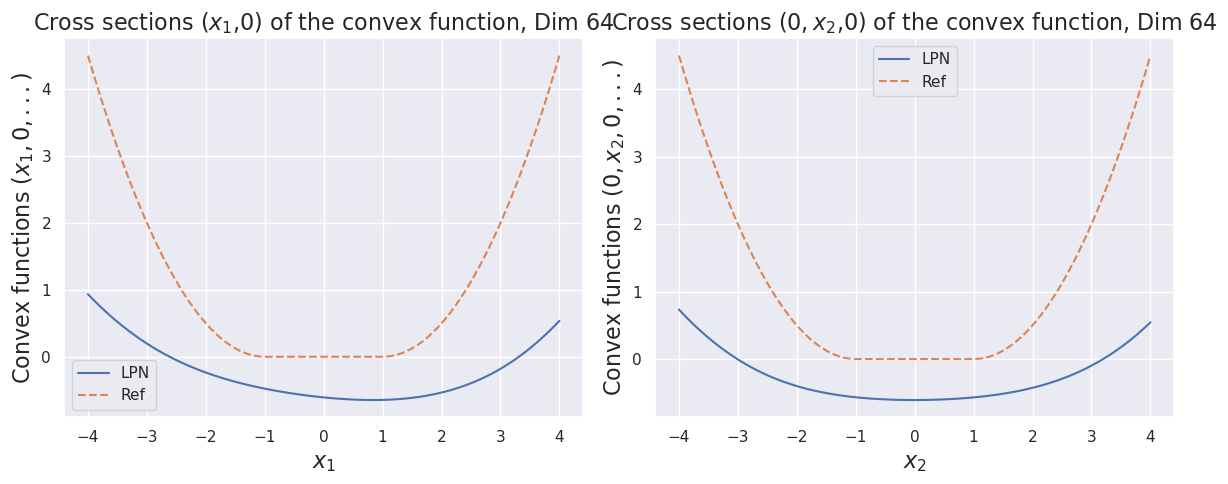

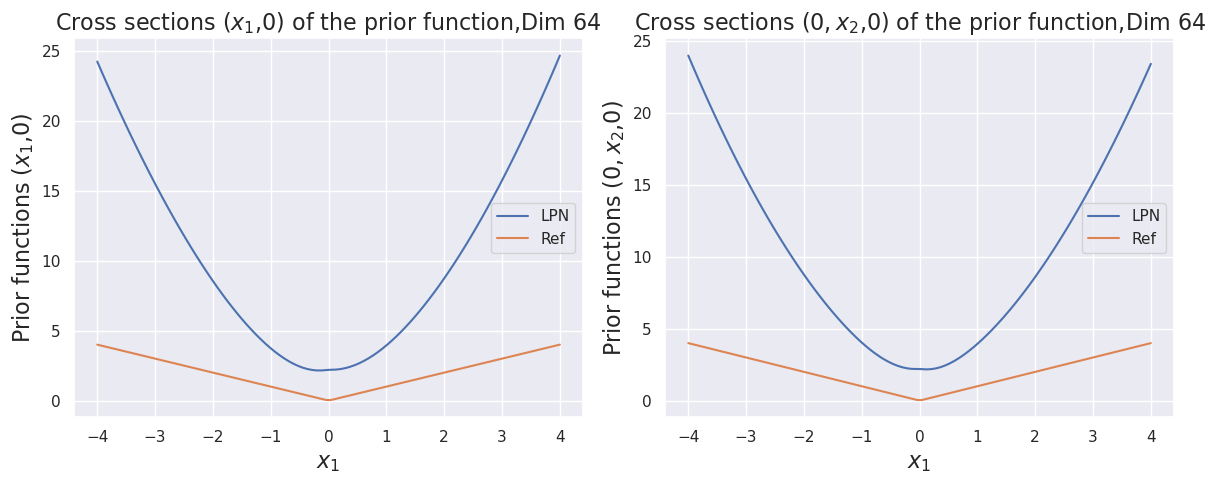

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 11488.9130859375
iteration 0 loss 6793.228515625


iteration 5000 loss 19.895328521728516


iteration 10000 loss 1.6018130779266357


iteration 15000 loss 0.3908902704715729


iteration 20000 loss 0.22009629011154175


iteration 25000 loss 0.14896215498447418


iteration 30000 loss 0.11375077813863754


iteration 35000 loss 0.09199260920286179


iteration 40000 loss 0.07510607689619064


iteration 45000 loss 0.0645781010389328


iteration 50000 loss 0.05566507577896118


iteration 55000 loss 0.04878861829638481


iteration 60000 loss 0.04398655891418457


iteration 65000 loss 0.03967777267098427


iteration 70000 loss 0.03630467504262924


iteration 75000 loss 0.033056650310754776


iteration 80000 loss 0.03086446411907673


iteration 85000 loss 0.028628606349229813


iteration 90000 loss 0.02656950242817402


iteration 95000 loss 0.02479267679154873


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.02326582930982113


iteration 105000 loss 0.02279510349035263


iteration 110000 loss 0.0214058980345726


iteration 115000 loss 0.020098088309168816


iteration 120000 loss 0.01876959577202797


iteration 125000 loss 0.01786734350025654


iteration 130000 loss 0.016777092590928078


iteration 135000 loss 0.01596873812377453


iteration 140000 loss 0.015083794482052326


iteration 145000 loss 0.014399596489965916


iteration 150000 loss 0.013652346096932888


iteration 155000 loss 0.01300765946507454


iteration 160000 loss 0.012420942075550556


iteration 165000 loss 0.011830640956759453


iteration 170000 loss 0.01136760227382183


iteration 175000 loss 0.010927454568445683


iteration 180000 loss 0.01044481061398983


iteration 185000 loss 0.010088806971907616


iteration 190000 loss 0.009663677774369717


iteration 195000 loss 0.009314784780144691


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.010275227949023247


iteration 205000 loss 0.00885728094726801


iteration 210000 loss 0.008491632528603077


iteration 215000 loss 0.008069050498306751


iteration 220000 loss 0.007678872440010309


iteration 225000 loss 0.0073188734240829945


iteration 230000 loss 0.0070120771415531635


iteration 235000 loss 0.0067107053473591805


iteration 240000 loss 0.006429772824048996


iteration 245000 loss 0.006186203099787235


iteration 250000 loss 0.0059401122853159904


iteration 255000 loss 0.005718780215829611


iteration 260000 loss 0.005507014691829681


iteration 265000 loss 0.005308832507580519


iteration 270000 loss 0.005133527331054211


iteration 275000 loss 0.004962774459272623


iteration 280000 loss 0.004791780840605497


iteration 285000 loss 0.0046257744543254375


iteration 290000 loss 0.004478935152292252


iteration 295000 loss 0.0043375552631914616


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.004194742534309626


iteration 305000 loss 0.004133815877139568


iteration 310000 loss 0.004036454018205404


iteration 315000 loss 0.003946009557694197


iteration 320000 loss 0.0038601181004196405


iteration 325000 loss 0.003777790814638138


iteration 330000 loss 0.0036985899787396193


iteration 335000 loss 0.0036220510955899954


iteration 340000 loss 0.0035480200313031673


iteration 345000 loss 0.0034761931747198105


iteration 350000 loss 0.0034064368810504675


iteration 355000 loss 0.003338610054925084


iteration 360000 loss 0.0032726379577070475


iteration 365000 loss 0.0032083792611956596


iteration 370000 loss 0.0031457445584237576


iteration 375000 loss 0.0030846786685287952


iteration 380000 loss 0.0030251014977693558


iteration 385000 loss 0.0029669736977666616


iteration 390000 loss 0.002910252194851637


iteration 395000 loss 0.0028548305854201317


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.002800693502649665


iteration 405000 loss 0.0027950836811214685


iteration 410000 loss 0.002788645215332508


iteration 415000 loss 0.0027825122233480215


iteration 420000 loss 0.0027765703853219748


iteration 425000 loss 0.0027707568369805813


iteration 430000 loss 0.0027650566771626472


iteration 435000 loss 0.0027594591956585646


iteration 440000 loss 0.002753949724137783


iteration 445000 loss 0.0027485128957778215


iteration 450000 loss 0.002743153367191553


iteration 455000 loss 0.00273786298930645


iteration 460000 loss 0.0027326366398483515


iteration 465000 loss 0.0027274710591882467


iteration 470000 loss 0.002722375327721238


iteration 475000 loss 0.0027173159178346395


iteration 480000 loss 0.002712321002036333


iteration 485000 loss 0.0027073717210441828


iteration 490000 loss 0.0027024622540920973


iteration 495000 loss 0.002697595162317157


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


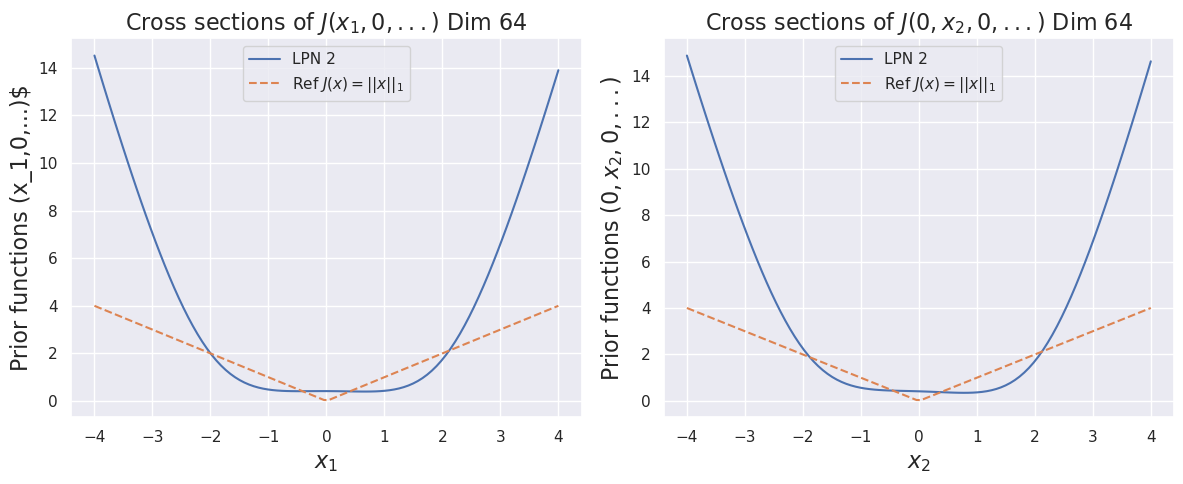

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions (x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)